# Analyse de l'incidence de la varicelle

## Obtention et pré-traitement des données

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek

Les données sur l'incidence de la varicelle sont disponible sur le site web [Réseau Sentinelles](https://www.sentiweb.fr/france/fr/?). Les données sont au format d'un fichier csv, où chaque ligne correspond à une semaine depuis l'année 1991 jusqu'à une semaine récente. Après téléchargement les données sont stockées localement, et re-téléchargées uniquement si le fichier n'est plus présent sur la machine.

In [2]:
data_url="https://www.sentiweb.fr/datasets/incidence-PAY-7.csv"
data_file="incidence-PAY-7.csv"
import os
import urllib.request
if not os.path.exists(data_file):
    urllib.request.urlretrieve(data_url, data_file)

Nous affichons un aperçu des données, la première ligne étant exclue car il s'agit d'un commentaire.

In [3]:
raw_data = pd.read_csv(data_file,skiprows=1)
raw_data

week  indicator    inc  inc_low  inc_up  inc100  inc100_low  \
0     202016          7    803       83    1523       1           0   
1     202015          7   1918      675    3161       3           1   
2     202014          7   3879     2227    5531       6           3   
3     202013          7   7326     5236    9416      11           8   
4     202012          7   8123     5790   10456      12           8   
5     202011          7  10198     7568   12828      15          11   
6     202010          7   9011     6691   11331      14          10   
7     202009          7  13631    10544   16718      21          16   
8     202008          7  10424     7708   13140      16          12   
9     202007          7   8959     6574   11344      14          10   
10    202006          7   9264     6925   11603      14          10   
11    202005          7   8505     6314   10696      13          10   
12    202004          7   7991     5831   10151      12           9   
13    202003          7   5968     4100    7836       9           6   
14    202002          7   6534     4530    8538      10           7   
15    202001          7   9835     7019   12651      15          11   
16    201952          7   7941     5246   10636      12           8   
17    201951          7   5823     3675    7971       9           6   
18    201950          7   6424     4276    8572      10           7   
19    201949          7   6621     4540    8702      10           7   
20    201948          7   5542     3383    7701       8           5   
21    201947          7   7536     5058   10014      11           7   
22    201946          7   2638     1316    3960       4           2   
23    201945          7   4492     2615    6369       7           4   
24    201944          7   5728     3627    7829       9           6   
25    201943          7   4834     2751    6917       7           4   
26    201942          7   6279     3989    8569      10           7   
27    201941          7   4130     2030    6230       6           3   
28    201940          7   4211     2218    6204       6           3   
29    201939          7   3137     1310    4964       5           2   
...      ...        ...    ...      ...     ...     ...         ...   
1503  199126          7  17608    11304   23912      31          20   
1504  199125          7  16169    10700   21638      28          18   
1505  199124          7  16171    10071   22271      28          17   
1506  199123          7  11947     7671   16223      21          13   
1507  199122          7  15452     9953   20951      27          17   
1508  199121          7  14903     8975   20831      26          16   
1509  199120          7  19053    12742   25364      34          23   
1510  199119          7  16739    11246   22232      29          19   
1511  199118          7  21385    13882   28888      38          25   
1512  199117          7  13462     8877   18047      24          16   
1513  199116          7  14857    10068   19646      26          18   
1514  199115          7  13975     9781   18169      25          18   
1515  199114          7  12265     7684   16846      22          14   
1516  199113          7   9567     6041   13093      17          11   
1517  199112          7  10864     7331   14397      19          13   
1518  199111          7  15574    11184   19964      27          19   
1519  199110          7  16643    11372   21914      29          20   
1520  199109          7  13741     8780   18702      24          15   
1521  199108          7  13289     8813   17765      23          15   
1522  199107          7  12337     8077   16597      22          15   
1523  199106          7  10877     7013   14741      19          12   
1524  199105          7  10442     6544   14340      18          11   
1525  199104          7   7913     4563   11263      14           8   
1526  199103          7  15387    10484   20290      27          18   
1527  199102          7  16277  

On recherche de potentielles incohérences sur le fichier de données. Il y a-t-il des données manquantes ?

In [4]:
raw_data[raw_data.isnull().any(axis=1)]

Empty DataFrame
Columns: [week, indicator, inc, inc_low, inc_up, inc100, inc100_low, inc100_up, geo_insee, geo_name]
Index: []

Parmis les semaines renseignées toutes contiennent des données. On cherche dorénavant à vérifier que toutes les semaines sont présentes. Pour cela on commence par convertir les numéros de semaine à l'aide du script qui suit, pour que Panda puisse les interpréter correctement.

In [5]:
data=raw_data
def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

data['period'] = [convert_week(yw) for yw in data['week']]

On effectue quelques modifications pour des raisons pratiques. Premièrement, nous définissons les périodes d'observation
comme nouvel index de notre jeux de données. Ceci en fait une suite chronologique.Deuxièmement, nous trions les points par période, dans le sens chronologique.

In [6]:
sorted_data = data.set_index('period').sort_index()

Il est maintenant possible de vérifier que toutes les semaines sont présentes. Pour cela on utilise un script permettant d'afficher les semaines qui seraient séparées d'un intervalle de temps non nul (fixé ici à 1 seconde)

In [7]:
periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

Aucune anomalie n'a été détecté dans le fichier du jeu de donnée, nous pouvons donc commencer l'analyse.

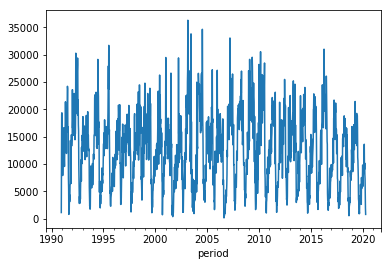

In [8]:
sorted_data['inc'].plot()

On remarque le présence de pics à intervalles réguliers. Mais le graphe obtenu est difficilement lisible, nous effectuons donc un zoom sur les dernières années

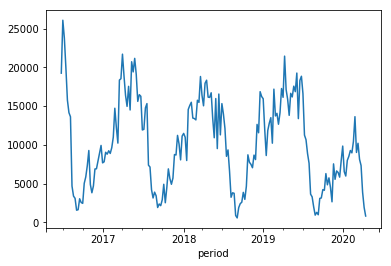

In [9]:
sorted_data['inc'][-200:].plot()

Avec cette vue plus précise, on remarque que le nombre de cas est très faible au début de l'automne, puis ne fait qu'augmenter au cours de l'année jusqu'à la fin de l'été où il chute pour retourner à une valeur similaire à celle de l'année précédente.

## Etude de l'incidence annuelle

On s'intéresse dorénavant au nombre de cas par années. Afin que le choix de la période n'impacte pas les résultats, nous définissons la période de référence entre deux minima de l'incidence, du 1er septembre de l'année $N$ au
1er septembre de l'année $N+1$.
Notre tâche est un peu compliquée par le fait que l'année ne comporte pas un nombre entier de semaines. Nous modifions donc un peu nos périodes de référence: à la place du 1er septembre de chaque année, nous utilisons le premier jour de la semaine qui contient le 1er septembre.Comme l'incidence de la varicelle est à son niveau le plus faible à cette période, cette modification ne risque pas de fausser nos conclusions.
Encore un petit détail: les données comencent en décembre 1990 et finissent en avril 2020, cela rend les années incomplètes. Nous démarrons donc l'analyse en 1991 et la finissons en 2019.

In [10]:
first_september_week = [pd.Period(pd.Timestamp(y, 9, 1), 'W')
                     for y in range(1991,
                                    sorted_data.index[-1].year)]

In [11]:
first_september_week

[Period('1991-08-26/1991-09-01', 'W-SUN'),
 Period('1992-08-31/1992-09-06', 'W-SUN'),
 Period('1993-08-30/1993-09-05', 'W-SUN'),
 Period('1994-08-29/1994-09-04', 'W-SUN'),
 Period('1995-08-28/1995-09-03', 'W-SUN'),
 Period('1996-08-26/1996-09-01', 'W-SUN'),
 Period('1997-09-01/1997-09-07', 'W-SUN'),
 Period('1998-08-31/1998-09-06', 'W-SUN'),
 Period('1999-08-30/1999-09-05', 'W-SUN'),
 Period('2000-08-28/2000-09-03', 'W-SUN'),
 Period('2001-08-27/2001-09-02', 'W-SUN'),
 Period('2002-08-26/2002-09-01', 'W-SUN'),
 Period('2003-09-01/2003-09-07', 'W-SUN'),
 Period('2004-08-30/2004-09-05', 'W-SUN'),
 Period('2005-08-29/2005-09-04', 'W-SUN'),
 Period('2006-08-28/2006-09-03', 'W-SUN'),
 Period('2007-08-27/2007-09-02', 'W-SUN'),
 Period('2008-09-01/2008-09-07', 'W-SUN'),
 Period('2009-08-31/2009-09-06', 'W-SUN'),
 Period('2010-08-30/2010-09-05', 'W-SUN'),
 Period('2011-08-29/2011-09-04', 'W-SUN'),
 Period('2012-08-27/2012-09-02', 'W-SUN'),
 Period('2013-08-26/2013-09-01', 'W-SUN'),
 Period('20

En partant de cette liste des semaines qui contiennent un 1er septembre, nous obtenons nos intervalles d'environ un an comme les périodes entre deux semaines adjacentes dans cette liste. Nous calculons les sommes des incidences hebdomadaires pour toutes ces périodes.Nous vérifions également que ces périodes contiennent entre 51 et 52 semaines, pour nous protéger contre des éventuelles erreurs dans notre code.

In [14]:
year = []
yearly_incidence = []

for week1, week2 in zip(first_september_week[:-1],
                        first_september_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

On présente désormais les incidences annuelles

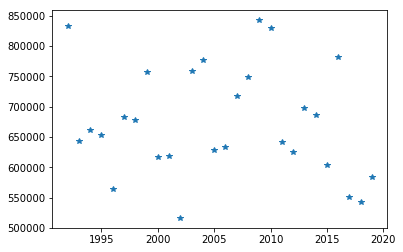

In [13]:
yearly_incidence.plot(style='*')

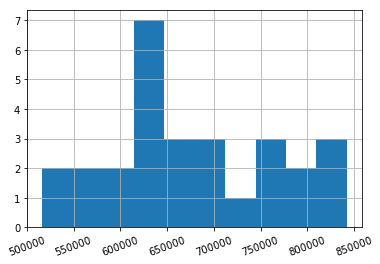

In [15]:
yearly_incidence.hist(xrot=20)

On peut également classer les années par nombre d'incidences

In [16]:
yearly_incidence.sort_values()

2002    516689
2018    542312
2017    551041
1996    564901
2019    584066
2015    604382
2000    617597
2001    619041
2012    624573
2005    628464
2006    632833
2011    642368
1993    643387
1995    652478
1994    661409
1998    677775
1997    683434
2014    685769
2013    698332
2007    717352
2008    749478
1999    756456
2003    758363
2004    777388
2016    782114
2010    829911
1992    832939
2009    842373
dtype: int64